# Imports

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import os
import cv2
import imutils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from google.colab.patches import cv2_imshow
from google.colab import drive

%matplotlib inline

# Mount

In [ ]:
# mount google drive directory
drive.mount('/content/drive/')

Mounted at /content/drive/


# Dataset path

In [ ]:
dataset_path = "./drive/MyDrive/wildfire_dataset/"

# Helper functions

## Unused functions

In [ ]:
# not used anymore
def get_data(folder, width, height):
    x = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith("."):
            # label with number according to folder
            if folderName in ["nofire"]:
                label = 1
            elif folderName in ["fire"]:
                label = 0
            else:
                label = 2
            for image_filename in os.listdir(folder +"/" +folderName+"/"):
                img_file = cv2.imread(folder + "/" +folderName + "/" + image_filename)
                img_file = cv2.cvtColor(img_file, cv2.COLOR_BGR2RGB) # convert to RGB
                img_file = cv2.normalize(img_file, img_file, 0, 255, cv2.NORM_MINMAX) # normalize the values between 0 and 255
                if img_file is not None:
                    img_file = cv2.resize(img_file, dsize=(width, height), interpolation=cv2.INTER_LINEAR) # decrease the image size
                    img_arr = np.asarray(img_file) # turn to numpy array
                    x.append(img_arr)
                    y.append(label)
    x = np.asarray(x)
    y = np.asarray(y)
    return x,y

In [ ]:
# not used anymore
def resize_image(image, width=None, height=None, inter=cv2.INTER_AREA):
    # check if the width and height is specified
    if width is None and height is None:
        return image

    # initialize the dimension of the image and grab the
    # width and height of the image
    dimension = None
    (h, w) = image.shape[:2]

    # calculate the ratio of the height and
    # construct the new dimension
    if height is not None:
        ratio = height / float(h)
        dimension = (int(w * ratio), height)
    else:
        ratio = width / float(w)
        dimension = (width, int(h * ratio))

    # resize the image
    resizedImage = cv2.resize(image, dimension, interpolation=inter)

    return resizedImage

## Confusion matrix function

In [ ]:
def confusion(y_test,y_test_pred,X):
    names=['Fire', 'No Fire']

    cm=confusion_matrix(y_test,y_test_pred)
    
    f,ax=plt.subplots(figsize=(5,5))

    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)

    plt.title(X, size = 25)

    plt.xlabel("y_pred")
    plt.ylabel("y_true")

    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

# Training a normal CNN
No data augmentation nor any kind of regularization

In [ ]:
#train = ImageDataGenerator(rescale=1/255) # no data augmentation
#test = ImageDataGenerator(rescale=1/255)

#train_dataset = train.flow_from_directory(dataset_path + "Training and Validation/",
                                          #target_size = (150, 150),
                                          #batch_size = 32,
                                          #class_mode = "binary")

#test_dataset = test.flow_from_directory(dataset_path + "Testing/",
                                          #target_size = (150, 150),
                                          #batch_size = 32,
                                          #class_mode = "binary")

In [ ]:
train = ImageDataGenerator(rescale=1./255, validation_split=0.2) # set validation split
test = ImageDataGenerator(rescale=1/255)

train_dataset = train.flow_from_directory(
    dataset_path + "Training and Validation/",
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training') # set as training data

validation_dataset = train.flow_from_directory(
    dataset_path + "Training and Validation/", # same directory as training data
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation') # set as validation data

test_dataset = test.flow_from_directory(
    dataset_path + "Testing/",
    target_size = (150, 150),
    batch_size = 32,
    class_mode = "binary")


Found 1467 images belonging to 2 classes.
Found 365 images belonging to 2 classes.
Found 68 images belonging to 2 classes.


In [ ]:
test_dataset.class_indices

{'fire': 0, 'nofire': 1}

In [ ]:
model = keras.Sequential()
# relu activation function used
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3))) # input shape corresponding to the image shape
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(128, (3,3), activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(128, (3,3), activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Flatten()) # flatten the image input tensor into a single dimension
# FC layer
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) # sigmoid function to bound the result between 0 and 1

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# train the model
r = model.fit(train_dataset, epochs=10, validation_data = validation_dataset)

Epoch 1/10
46/46 [==============================] - 350s 7s/step - loss: 0.3227 - accuracy: 0.8562 - val_loss: 0.2252 - val_accuracy: 0.9205
Epoch 2/10
46/46 [==============================] - 5s 119ms/step - loss: 0.1417 - accuracy: 0.9536 - val_loss: 0.2311 - val_accuracy: 0.9123
Epoch 3/10
46/46 [==============================] - 6s 139ms/step - loss: 0.1546 - accuracy: 0.9461 - val_loss: 0.2243 - val_accuracy: 0.9260
Epoch 4/10
46/46 [==============================] - 5s 118ms/step - loss: 0.1215 - accuracy: 0.9639 - val_loss: 0.2915 - val_accuracy: 0.9123
Epoch 5/10
46/46 [==============================] - 6s 133ms/step - loss: 0.1030 - accuracy: 0.9707 - val_loss: 0.1616 - val_accuracy: 0.9479
Epoch 6/10
46/46 [==============================] - 6s 120ms/step - loss: 0.0718 - accuracy: 0.9789 - val_loss: 0.1893 - val_accuracy: 0.9452
Epoch 7/10
46/46 [==============================] - 6s 139ms/step - loss: 0.0512 - accuracy: 0.9830 - val_loss: 0.2078 - val_accuracy: 0.9507
Epoch 8

In [ ]:
# evaluate the model on test data
model.evaluate(test_dataset)

3/3 [==============================] - 13s 7s/step - loss: 0.1988 - accuracy: 0.9118


[0.1988006830215454, 0.9117646813392639]

In [ ]:
# make predictions to compare with actual labels
# round it so that we get binary results
y_pred = np.round(model.predict(test.flow_from_directory(dataset_path + "Testing/",
                                                         target_size = (150, 150),
                                                         batch_size = 32, shuffle=False, # shuffle false so that it's in the same order as the labels
                                                         class_mode = "binary"))) # binary classification

Found 68 images belonging to 2 classes.
3/3 [==============================] - 0s 57ms/step


In [ ]:
print(classification_report(test_dataset.labels, y_pred)) # classification report

              precision    recall  f1-score   support

           0       0.79      1.00      0.88        22
           1       1.00      0.87      0.93        46

    accuracy                           0.91        68
   macro avg       0.89      0.93      0.91        68
weighted avg       0.93      0.91      0.91        68



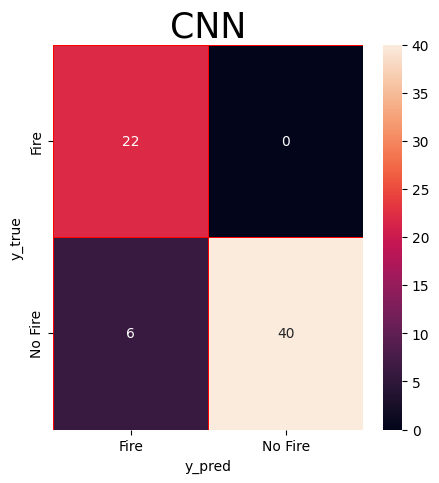

In [ ]:
print(confusion(test_dataset.labels, y_pred, "CNN")) # confusion matrix

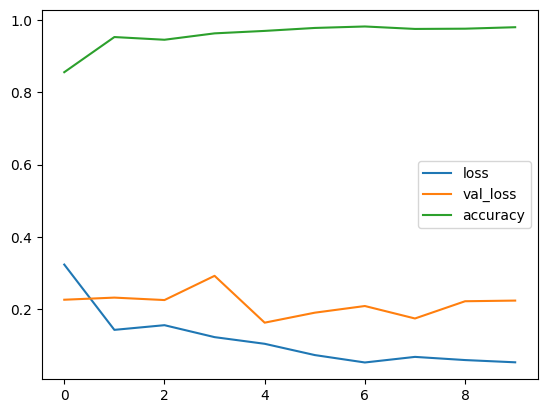

In [ ]:
# plot losses and accuracy
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.plot(r.history['accuracy'], label='accuracy')
plt.legend()

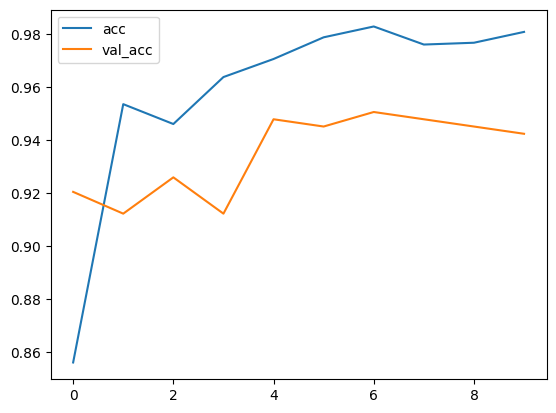

In [ ]:
# plot training and validation accuracy
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [ ]:
def predictImage(filename):
    img1 = image.load_img(filename,target_size=(150,150))
    plt.imshow(img1)
    Y = image.img_to_array(img1)
    X = np.expand_dims(Y,axis=0)
    val = model.predict(X)
    print(val)
    if val == 1:
        plt.xlabel("No Fire",fontsize=30)
    elif val == 0:
        plt.xlabel("Fire",fontsize=30)

1/1 [==============================] - 0s 295ms/step
[[0.]]


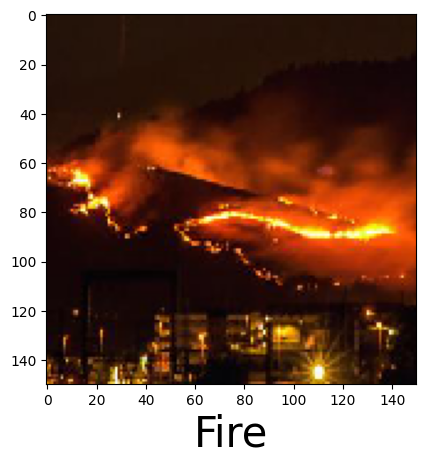

In [ ]:
predictImage(dataset_path + "Testing/fire/abc182.jpg")

1/1 [==============================] - 0s 18ms/step
[[1.]]


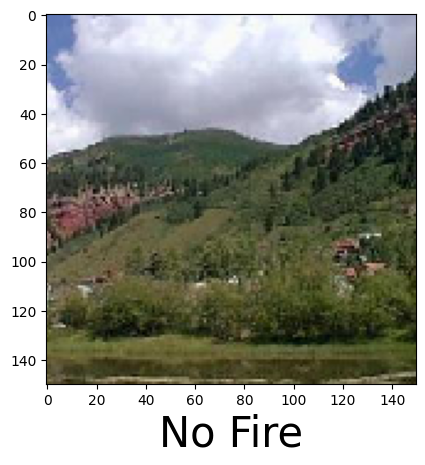

In [ ]:
predictImage(dataset_path + "Testing/nofire/abc346.jpg")

# Trying to improve the model

## Data Augmentation

In [ ]:
train = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

test = ImageDataGenerator(rescale=1/255) # the validation dataset shouldn't be augmented

train_dataset = train.flow_from_directory(
    dataset_path + "Training and Validation/",
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training') # set as training data

validation_dataset = train.flow_from_directory(
    dataset_path + "Training and Validation/", # same directory as training data
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation') # set as validation data


test_dataset = test.flow_from_directory(
    dataset_path + "Testing/",
    target_size = (150, 150),
    batch_size = 32,
    class_mode = "binary")

Found 1467 images belonging to 2 classes.
Found 365 images belonging to 2 classes.
Found 68 images belonging to 2 classes.


In [ ]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(128, (3,3), activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(128, (3,3), activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
r = model.fit(train_dataset, epochs=15, validation_data = validation_dataset)

Epoch 1/15
46/46 [==============================] - 21s 350ms/step - loss: 0.2190 - accuracy: 0.9196 - val_loss: 0.3196 - val_accuracy: 0.8986
Epoch 2/15
46/46 [==============================] - 15s 322ms/step - loss: 0.1536 - accuracy: 0.9448 - val_loss: 0.2724 - val_accuracy: 0.9014
Epoch 3/15
46/46 [==============================] - 15s 332ms/step - loss: 0.1416 - accuracy: 0.9468 - val_loss: 0.2499 - val_accuracy: 0.9041
Epoch 4/15
46/46 [==============================] - 19s 408ms/step - loss: 0.1351 - accuracy: 0.9571 - val_loss: 0.2261 - val_accuracy: 0.9068
Epoch 5/15
46/46 [==============================] - 15s 323ms/step - loss: 0.1120 - accuracy: 0.9577 - val_loss: 0.2210 - val_accuracy: 0.9288
Epoch 6/15
46/46 [==============================] - 15s 323ms/step - loss: 0.1176 - accuracy: 0.9625 - val_loss: 0.2019 - val_accuracy: 0.9233
Epoch 7/15
46/46 [==============================] - 15s 321ms/step - loss: 0.1026 - accuracy: 0.9598 - val_loss: 0.1998 - val_accuracy: 0.9342

In [ ]:
model.evaluate(test_dataset)

3/3 [==============================] - 0s 51ms/step - loss: 0.0976 - accuracy: 0.9706


[0.09758608788251877, 0.970588207244873]

In [ ]:
y_pred = np.round(model.predict(test.flow_from_directory(dataset_path + "Testing/",
                                                         target_size = (150, 150),
                                                         batch_size = 32, shuffle=False,
                                                         class_mode = "binary")))

Found 68 images belonging to 2 classes.


3/3 [==============================] - 0s 66ms/step


In [ ]:
print(classification_report(test_dataset.labels, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        22
           1       0.98      0.98      0.98        46

    accuracy                           0.97        68
   macro avg       0.97      0.97      0.97        68
weighted avg       0.97      0.97      0.97        68



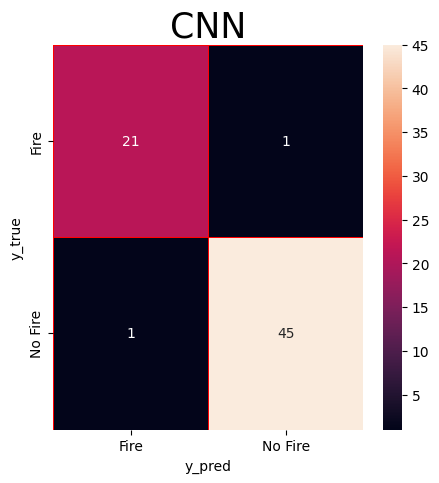

In [ ]:
print(confusion(test_dataset.labels, y_pred, "CNN"))

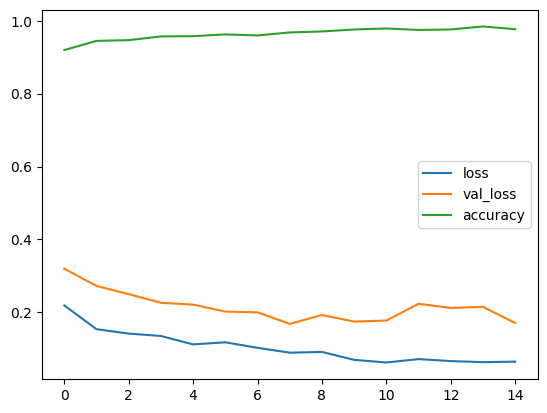

In [ ]:
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.plot(r.history['accuracy'], label='accuracy')
plt.legend()

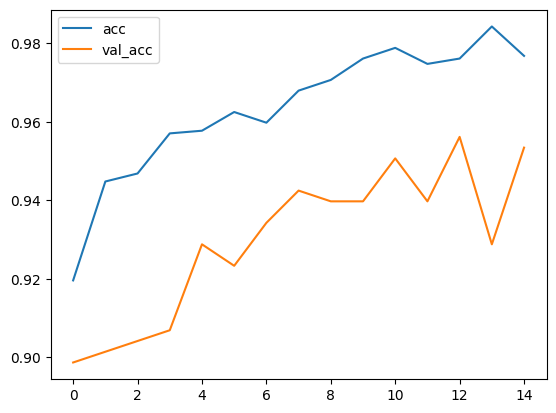

In [ ]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

## Adding batch normalization, dropout, early stopping

In [ ]:
train = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

test = ImageDataGenerator(rescale=1/255)

train_dataset = train.flow_from_directory(
    dataset_path + "Training and Validation/",
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training') # set as training data

validation_dataset = train.flow_from_directory(
    dataset_path + "Training and Validation/", # same directory as training data
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation') # set as validation data


test_dataset = test.flow_from_directory(
    dataset_path + "Testing/",
    target_size = (150, 150),
    batch_size = 32,
    class_mode = "binary")

Found 1467 images belonging to 2 classes.
Found 365 images belonging to 2 classes.
Found 68 images belonging to 2 classes.


In [ ]:
model = keras.Sequential()

model.add(keras.layers.Conv2D(64,(3,3),activation="relu",input_shape=(150,150,3)))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Conv2D(64,(3,3),activation="relu"))
model.add(keras.layers.MaxPooling2D((2,2)))

model.add(keras.layers.Conv2D(64,(3,3),activation="relu"))
model.add(keras.layers.MaxPooling2D((2,2)))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(128,activation="relu"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1,activation="sigmoid"))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

custom_early_stopping = EarlyStopping(
    monitor='accuracy', # what result to monitor
    patience=30, # how many epochs without improvement
    restore_best_weights=True
)

In [ ]:
r = model.fit(train_dataset, epochs=100, validation_data = validation_dataset, callbacks=[custom_early_stopping])

Epoch 1/100
46/46 [==============================] - 19s 351ms/step - loss: 0.2496 - accuracy: 0.9100 - val_loss: 0.8333 - val_accuracy: 0.5068
Epoch 2/100
46/46 [==============================] - 15s 326ms/step - loss: 0.1924 - accuracy: 0.9325 - val_loss: 0.8212 - val_accuracy: 0.5068
Epoch 3/100
46/46 [==============================] - 15s 338ms/step - loss: 0.1549 - accuracy: 0.9421 - val_loss: 0.8578 - val_accuracy: 0.5068
Epoch 4/100
46/46 [==============================] - 18s 385ms/step - loss: 0.1474 - accuracy: 0.9427 - val_loss: 0.8008 - val_accuracy: 0.5068
Epoch 5/100
46/46 [==============================] - 17s 362ms/step - loss: 0.1443 - accuracy: 0.9434 - val_loss: 0.6995 - val_accuracy: 0.5096
Epoch 6/100
46/46 [==============================] - 18s 380ms/step - loss: 0.1392 - accuracy: 0.9489 - val_loss: 0.6066 - val_accuracy: 0.5397
Epoch 7/100
46/46 [==============================] - 15s 330ms/step - loss: 0.1329 - accuracy: 0.9564 - val_loss: 0.6015 - val_accuracy:

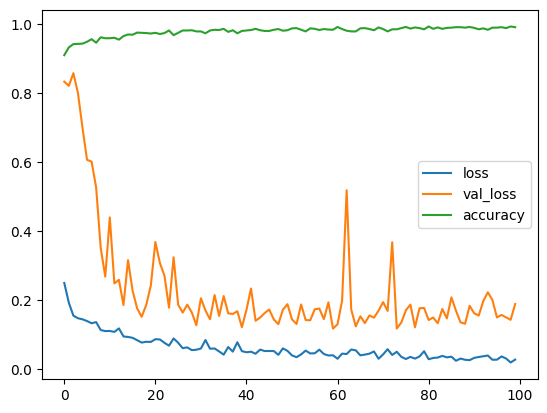

In [ ]:
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.plot(r.history['accuracy'], label='accuracy')
plt.legend()

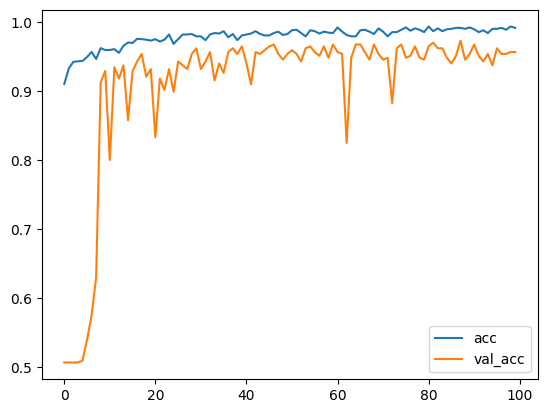

In [ ]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [ ]:
model.evaluate(test_dataset)

3/3 [==============================] - 0s 133ms/step - loss: 0.1901 - accuracy: 0.9706


[0.19005538523197174, 0.970588207244873]

In [ ]:
y_pred = np.round(model.predict(test.flow_from_directory(dataset_path + "Testing/",
                                                         target_size = (150, 150),
                                                         batch_size = 32, shuffle=False,
                                                         class_mode = "binary")))

Found 68 images belonging to 2 classes.


3/3 [==============================] - 0s 54ms/step


In [ ]:
print(classification_report(test_dataset.labels, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        22
           1       0.98      0.98      0.98        46

    accuracy                           0.97        68
   macro avg       0.97      0.97      0.97        68
weighted avg       0.97      0.97      0.97        68



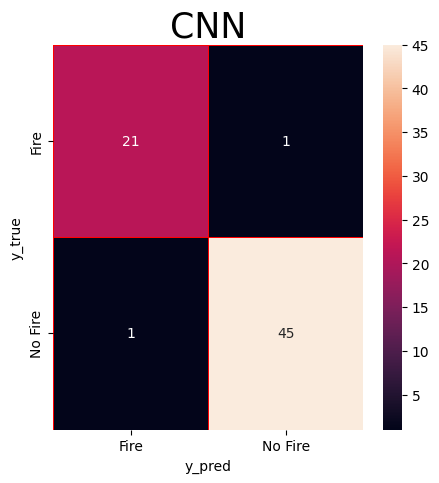

In [ ]:
print(confusion(test_dataset.labels, y_pred, "CNN"))

## Transfer learning using MobileNetV2

In [ ]:
train = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

test = ImageDataGenerator(rescale=1/255)

train_dataset = train.flow_from_directory(
    dataset_path + "Training and Validation/",
    target_size=(160, 160),
    batch_size=32,
    class_mode='binary',
    subset='training') # set as training data

validation_dataset = train.flow_from_directory(
    dataset_path + "Training and Validation/", # same directory as training data
    target_size=(160, 160),
    batch_size=32,
    class_mode='binary',
    subset='validation') # set as validation data


test_dataset = test.flow_from_directory(
    dataset_path + "Testing/",
    target_size = (160, 160),
    batch_size = 32,
    class_mode = "binary")

Found 1467 images belonging to 2 classes.
Found 365 images belonging to 2 classes.
Found 68 images belonging to 2 classes.


In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(160, 160, 3),
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
base_model.trainable = False

In [ ]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Apply dropout with a rate of 0.5
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
inputs = base_model.inputs
model = tf.keras.Model(inputs, output)

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer = tf.keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset,
                    epochs=10, validation_data=validation_dataset)

Epoch 1/10
46/46 [==============================] - 20s 365ms/step - loss: 0.1528 - accuracy: 0.9237 - val_loss: 0.1228 - val_accuracy: 0.9534
Epoch 2/10
46/46 [==============================] - 21s 461ms/step - loss: 0.0592 - accuracy: 0.9768 - val_loss: 0.2109 - val_accuracy: 0.9288
Epoch 3/10
46/46 [==============================] - 16s 350ms/step - loss: 0.0681 - accuracy: 0.9775 - val_loss: 0.1237 - val_accuracy: 0.9699
Epoch 4/10
46/46 [==============================] - 16s 351ms/step - loss: 0.0324 - accuracy: 0.9877 - val_loss: 0.1080 - val_accuracy: 0.9726
Epoch 5/10
46/46 [==============================] - 18s 389ms/step - loss: 0.0381 - accuracy: 0.9864 - val_loss: 0.0961 - val_accuracy: 0.9726
Epoch 6/10
46/46 [==============================] - 16s 348ms/step - loss: 0.0406 - accuracy: 0.9898 - val_loss: 0.1401 - val_accuracy: 0.9726
Epoch 7/10
46/46 [==============================] - 16s 351ms/step - loss: 0.0241 - accuracy: 0.9939 - val_loss: 0.0818 - val_accuracy: 0.9753

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100

base_model.trainable = True

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer = tf.keras.optimizers.RMSprop(lr=0.0001),
              metrics=['accuracy'])

In [ ]:
fine_tune_epochs = 20
total_epochs =  10 + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],validation_data=validation_dataset)

Epoch 10/30
46/46 [==============================] - 27s 370ms/step - loss: 0.2592 - accuracy: 0.9502 - val_loss: 1.8627 - val_accuracy: 0.8466
Epoch 11/30
46/46 [==============================] - 16s 352ms/step - loss: 0.1368 - accuracy: 0.9598 - val_loss: 0.4521 - val_accuracy: 0.9260
Epoch 12/30
46/46 [==============================] - 20s 421ms/step - loss: 0.0692 - accuracy: 0.9741 - val_loss: 7.2538 - val_accuracy: 0.5753
Epoch 13/30
46/46 [==============================] - 16s 354ms/step - loss: 0.0762 - accuracy: 0.9796 - val_loss: 10.2296 - val_accuracy: 0.6466
Epoch 14/30
46/46 [==============================] - 16s 350ms/step - loss: 0.0589 - accuracy: 0.9802 - val_loss: 0.4062 - val_accuracy: 0.9616
Epoch 15/30
46/46 [==============================] - 16s 352ms/step - loss: 0.0478 - accuracy: 0.9864 - val_loss: 0.4901 - val_accuracy: 0.9589
Epoch 16/30
46/46 [==============================] - 18s 400ms/step - loss: 0.0479 - accuracy: 0.9898 - val_loss: 0.4285 - val_accuracy

In [ ]:
model.evaluate(test_dataset)

3/3 [==============================] - 0s 58ms/step - loss: 8.7950e-07 - accuracy: 1.0000


[8.794999644123891e-07, 1.0]

In [ ]:
y_pred = np.round(model.predict(test.flow_from_directory(dataset_path + "Testing/",
                                                         target_size = (160, 160),
                                                         batch_size = 32, shuffle=False,
                                                         class_mode = "binary")))

Found 68 images belonging to 2 classes.
3/3 [==============================] - 1s 66ms/step


In [ ]:
print(classification_report(test_dataset.labels, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        46

    accuracy                           1.00        68
   macro avg       1.00      1.00      1.00        68
weighted avg       1.00      1.00      1.00        68



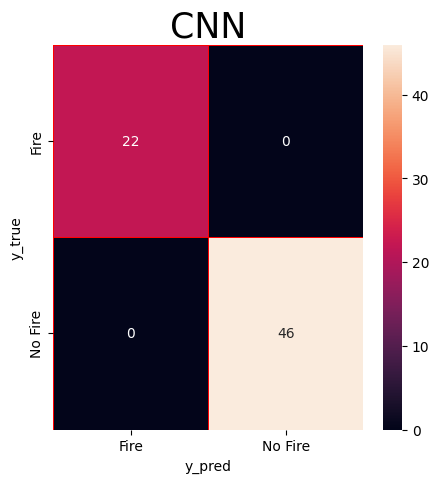

In [ ]:
print(confusion(test_dataset.labels, y_pred, "CNN"))

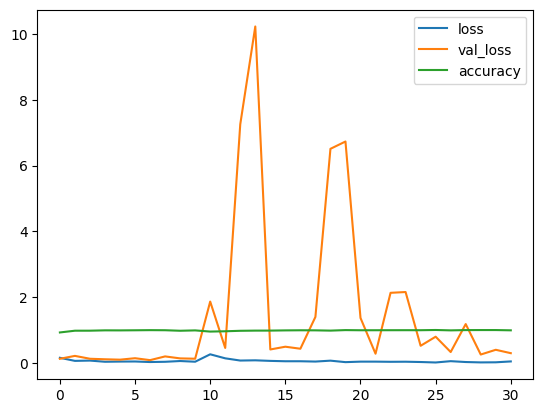

In [ ]:
plt.plot(np.hstack((history.history['loss'],history_fine.history['loss'])), label='loss')
plt.plot(np.hstack((history.history['val_loss'],history_fine.history['val_loss'])), label='val_loss')
plt.plot(np.hstack((history.history['accuracy'],history_fine.history['accuracy'])), label='accuracy')
plt.legend()

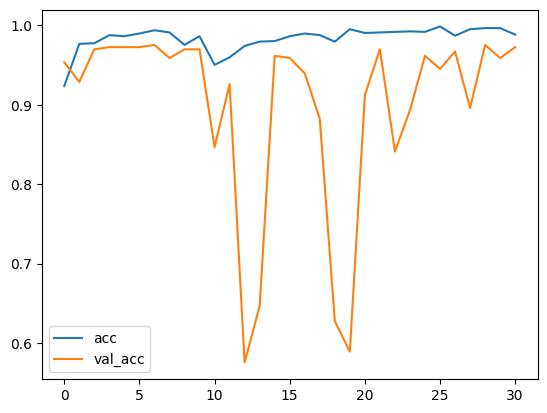

In [ ]:
plt.plot(np.hstack((history.history['accuracy'],history_fine.history['accuracy'])), label='acc')
plt.plot(np.hstack((history.history['val_accuracy'],history_fine.history['val_accuracy'])), label='val_acc')
plt.legend()